In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import networkx as nx
from collections import Counter
from sklearn.preprocessing import MinMaxScaler 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import random
import uproot

In [ ]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Load data

In [ ]:
path_to_tree = "DecayTreeTuple/tuple"

def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if "_BDTTag_" in col:
            new_columns[col] = col.replace("_BDTTag_", "_SVtag_")
    df.rename(columns=new_columns, inplace=True)

# maybe don't need
def extract_float(awk_array):
    return awk_array[0] if len(awk_array) > 0 else None

In [2]:
# Read the ROOT file
tree = uproot.open("Dijet_bb_pt20_50_dw.root" + ":" + path_to_tree)
bb_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=600000) #1000-2000 events read in

# Clean column names and remove unwanted columns
bb_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in bb_df.columns]
rename_columns(bb_df)
columns_to_remove = [col for col in bb_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
bb_df.drop(columns=columns_to_remove, inplace=True)
for col in bb_df.columns:
    if "SVtag" in col:
        bb_df[col] = bb_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_cc_pt20_50_dw.root" + ":" + path_to_tree)
cc_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=600000) #1000-2000 events read in

# Clean column names and remove unwanted columns
cc_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in cc_df.columns]
rename_columns(cc_df)
columns_to_remove = [col for col in cc_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
cc_df.drop(columns=columns_to_remove, inplace=True)
for col in cc_df.columns:
    if "SVtag" in col:
        cc_df[col] = cc_df[col].apply(extract_float)
tree.close()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 418 columns):
 #    Column                               Dtype  
---   ------                               -----  
 0    Jet0_ENDVERTEX_X                     float64
 1    Jet0_ENDVERTEX_Y                     float64
 2    Jet0_ENDVERTEX_Z                     float64
 3    Jet0_ENDVERTEX_XERR                  float64
 4    Jet0_ENDVERTEX_YERR                  float64
 5    Jet0_ENDVERTEX_ZERR                  float64
 6    Jet0_ENDVERTEX_CHI2                  float64
 7    Jet0_ENDVERTEX_NDOF                  int32  
 8    Jet0_OWNPV_X                         float64
 9    Jet0_OWNPV_Y                         float64
 10   Jet0_OWNPV_Z                         float64
 11   Jet0_OWNPV_XERR                      float64
 12   Jet0_OWNPV_YERR                      float64
 13   Jet0_OWNPV_ZERR                      float64
 14   Jet0_OWNPV_CHI2                      float64
 15   Jet0_OWNPV_NDOF

In [54]:
# Read from csv
sig_df = cc_df
bkg_df = bb_df

full_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

# Distinguish signal and background
sig_df['IsC'] = 1
bkg_df['IsC'] = 0

# Only include leading jet data and truth labels
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsC")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsC")]]

# Truth matching and cuts
sig_df = sig_df[(sig_df['Jet0_MC_Match'] == 1) &
                (sig_df['Jet0_MC_Jet_EfD'] > 0.6) &
                (sig_df['Jet0_PT'] > 20000) &
                (sig_df['Jet0_Eta'].between(2.2, 4.4))]
bkg_df = bkg_df[(bkg_df['Jet0_MC_Match'] == 1) &
                (bkg_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (bkg_df['Jet0_PT'] > 20000) &
                (bkg_df['Jet0_Eta'].between(2.2, 4.4))]


print("Efficiency of signal truth matching is: %f" (len(sig_df)/ len(full_df))) ####
print("Efficiency of background truth matching is: %f" (len(bkg_df)/ len(full_df))) ####

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)
full_df = combined_df.copy()

# Define daughter and jet-level features, including sv tagging
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

In [55]:
for col in daughter_cols:
    full_df[col] = full_df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

In [56]:
# Split data 80:20 w equal parts sig/bkg then shuffle
sig_df = full_df[full_df['IsC'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = full_df[full_df['IsC'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

train_size = 160000
test_size = 40000

train_df = pd.concat([sig_df.head(train_size), bkg_df.head(train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_df.tail(test_size), bkg_df.tail(test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
validation_df = pd.concat([sig_df.iloc[train_size:-test_size], bkg_df.iloc[train_size:-test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)

In [57]:
train_sig_df = train_df[train_df['IsC'] == 1]
train_bkg_df = train_df[train_df['IsC'] == 0]

In [58]:
full_sig_df = full_df[full_df['IsC'] == 1]
full_bkg_df = full_df[full_df['IsC'] == 0]

In [59]:
full_sig_df = full_sig_df.head(200000)

In [60]:
full_bkg_df = full_bkg_df.head(200000)

Plot features data

In [61]:
def get_lists(col):
    sig_list = []
    bkg_list = []

    for i, row in train_sig_df.iterrows():
        vals = row[col]
        if isinstance(vals, list):
            sig_list.extend(vals)
        else:
            sig_list.append(vals)

    for i, row in train_bkg_df.iterrows():
        vals = row[col]
        if isinstance(vals, list):
            bkg_list.extend(vals)
        else:
            bkg_list.append(vals)
    return sig_list, bkg_list

In [62]:
important_features = ['Jet0_Daughters_E',
'Jet0_Daughters_pT',
'Jet0_Daughters_pZ',
'Jet0_Daughters_IPCHI2',
'Jet0_Daughters_NNmu',
'Jet0_Daughters_trackZ',
'Jet0_Daughters_trackVZ',
'Jet0_Daughters_CaloNeutralEcal',
'Jet0_Daughters_CaloNeutralHcal2Ecal',
'Jet0_Daughters_CaloNeutralE49',
'Jet0_Daughters_CaloNeutralPrs',
'Jet0_PT',
'Jet0_SVtag_m',
'Jet0_SVtag_mCor',
'Jet0_SVtag_fdChi2',
'Jet0_SVtag_ipChi2Sum',
'Jet0_SVtag_pt']

In [63]:
E_sig, E_bkg = get_lists('Jet0_Daughters_E')

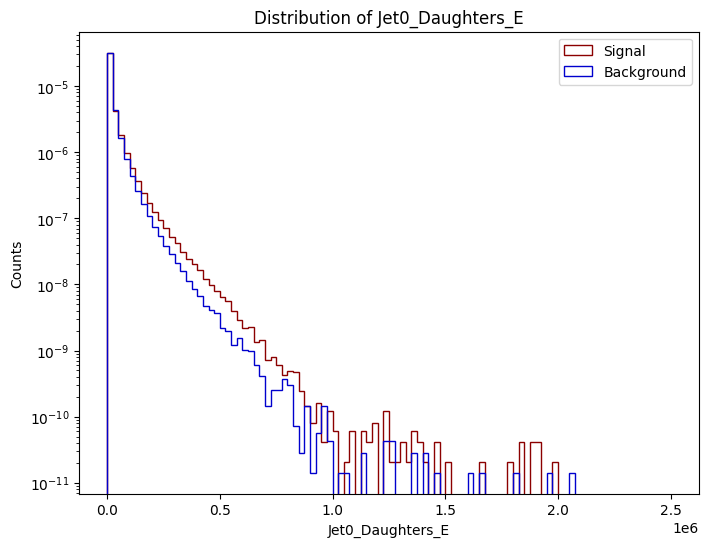

In [64]:
plt.figure(figsize=(8, 6))
plt.hist(E_sig, label="Signal", range=[0,2.5e6], bins=100, histtype='step', color='darkred', density=True)
plt.hist(E_bkg, label="Background", range=[0,2.5e6], bins=100, histtype='step', color='mediumblue', density=True)
plt.xlabel('Jet0_Daughters_E')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Distribution of Jet0_Daughters_E')
plt.legend(loc='best')
plt.show()

In [65]:
PT_sig, PT_bkg = get_lists('Jet0_PT')

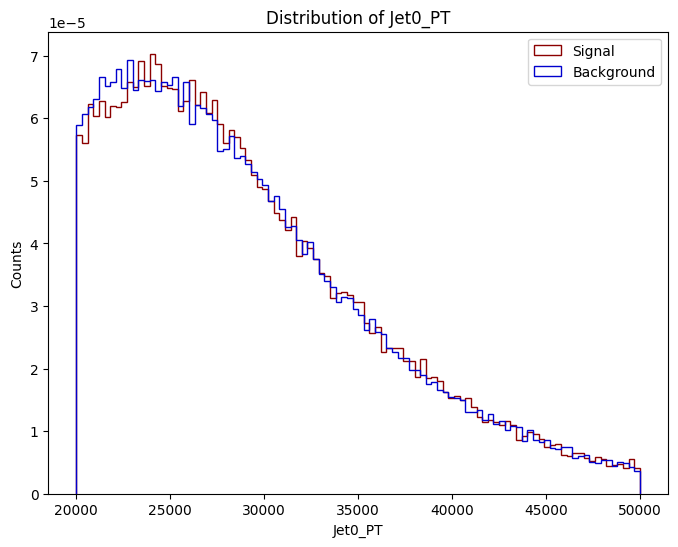

In [66]:
plt.figure(figsize=(8, 6))
plt.hist(PT_sig, label="Signal", range=[20000,50000], bins=100, histtype='step', color='darkred', density=True)
plt.hist(PT_bkg, label="Background", range=[20000,50000], bins=100, histtype='step', color='mediumblue', density=True)
plt.xlabel('Jet0_PT')
plt.ylabel('Counts')
plt.yscale('linear')
plt.title('Distribution of Jet0_PT')
plt.legend(loc='best')
plt.show()

In [67]:
def plot_features(col, scale, range, bins):
    sig_list, bkg_list = get_lists(col)

    plt.figure(figsize=(8, 6))
    plt.hist(sig_list, label="Signal", range=range, bins=bins, histtype='step', color='darkred', density=True)
    plt.hist(bkg_list, label="Background", range=range, bins=bins, histtype='step', color='mediumblue', density=True)
    plt.xlabel(f'{col}')
    plt.ylabel('Counts')
    plt.yscale(scale)
    plt.title(f'Distribution of {col}')
    plt.legend(loc='best')
    plt.show()

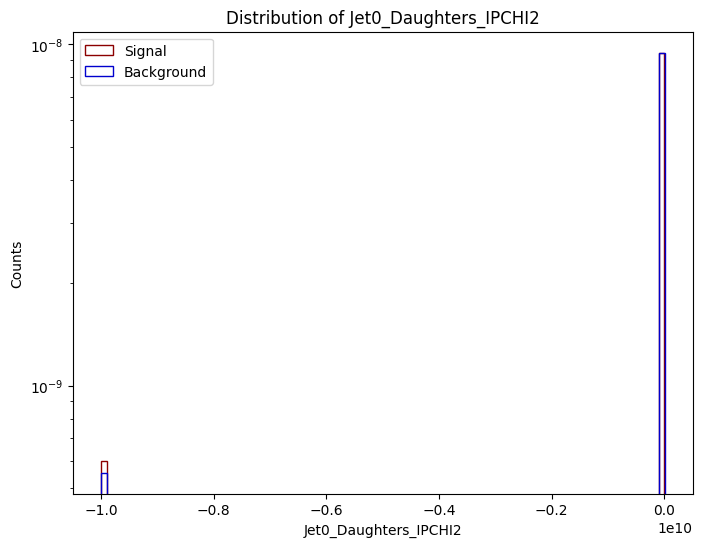

In [68]:
plot_features('Jet0_Daughters_IPCHI2', 'log', None, 100)

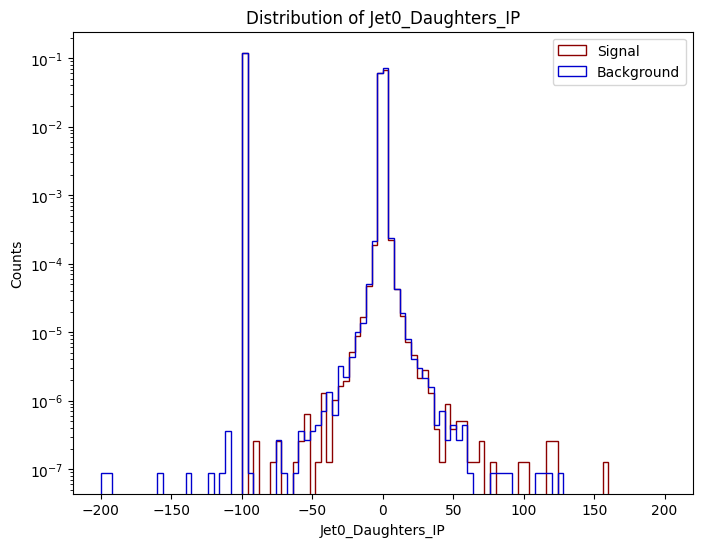

In [69]:
plot_features('Jet0_Daughters_IP', 'log', [-200, 200], 100)

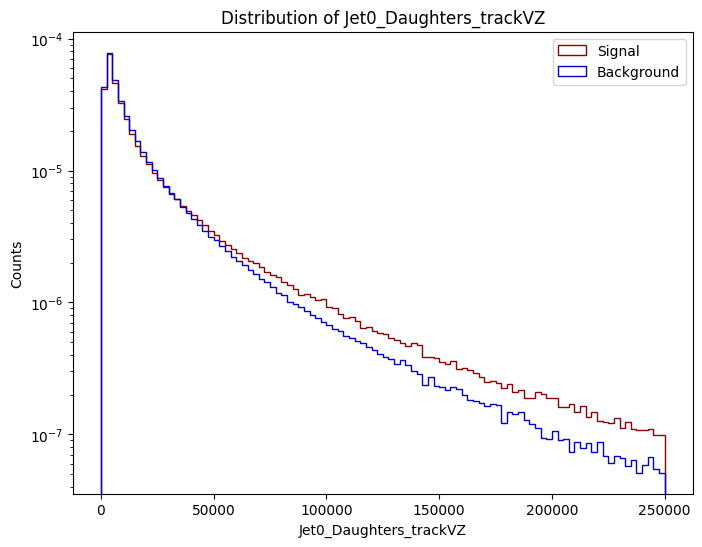

In [70]:
plot_features('Jet0_Daughters_trackVZ', 'log', [0,0.25e6], 100)

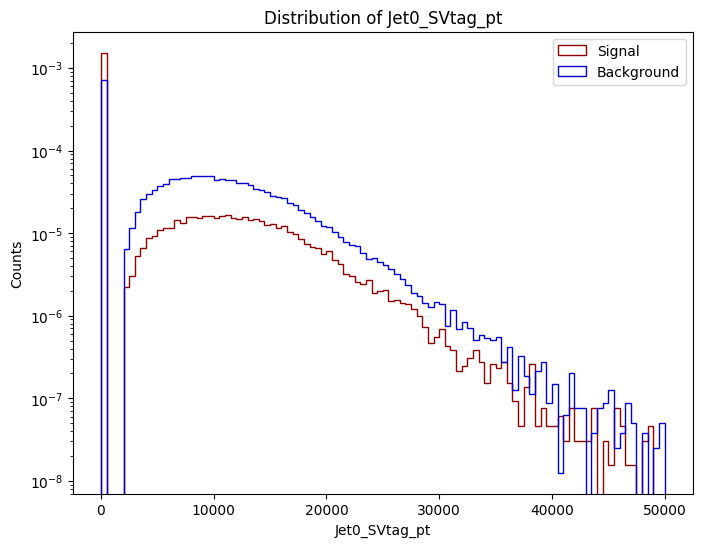

In [71]:
plot_features('Jet0_SVtag_pt', 'log', [0,50000], 100)

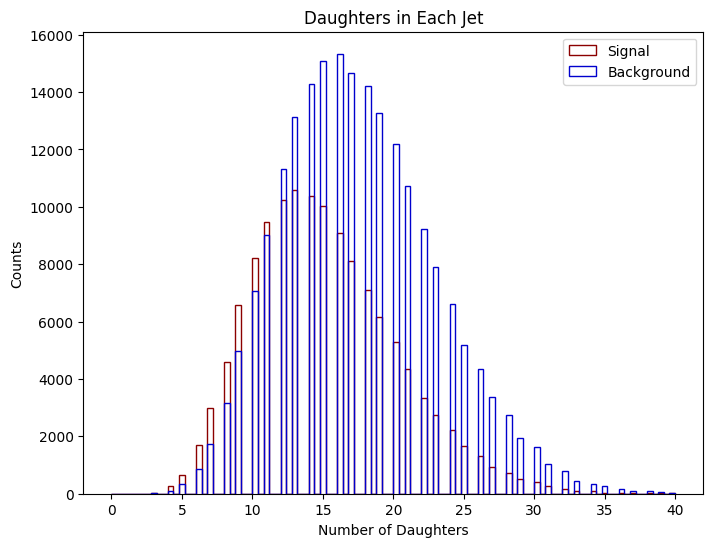

In [72]:
plt.figure(figsize=(8, 6))
plt.hist(sig_df.Jet0_nDaughters, label="Signal", range=[0,40], bins=100, histtype='step', color='darkred')
plt.hist(bkg_df.Jet0_nDaughters, label="Background", range=[0,40], bins=100, histtype='step', color='mediumblue')
plt.xlabel('Number of Daughters')
plt.ylabel("Counts")
plt.legend(loc='best')
plt.title('Daughters in Each Jet'); 
plt.show()

In [73]:
sig_id_list = []
bkg_id_list = []

for i, row in sig_df.iterrows():
    numbers = [float(num) for num in row['Jet0_Daughters_ID']]
    sig_id_list.extend(numbers)

for i, row in bkg_df.iterrows():
    numbers = [float(num) for num in row['Jet0_Daughters_ID']]
    bkg_id_list.extend(numbers)

In [74]:
sig_id_counts = Counter(sig_id_list)
bkg_id_counts = Counter(bkg_id_list)

In [75]:
sig_id_counts

Counter({22.0: 808091,
         211.0: 392047,
         -211.0: 385430,
         -22.0: 118298,
         321.0: 49067,
         -321.0: 47811,
         310.0: 37144,
         -11.0: 25132,
         11.0: 24298,
         111.0: 20307,
         2212.0: 18208,
         -2212.0: 16942,
         3122.0: 5090,
         -3122.0: 5078,
         -13.0: 4614,
         13.0: 4479})

In [76]:
bkg_id_counts

Counter({22.0: 1491791,
         211.0: 709360,
         -211.0: 696576,
         -22.0: 202261,
         310.0: 118196,
         321.0: 87698,
         -321.0: 85976,
         -11.0: 45092,
         11.0: 43716,
         111.0: 34642,
         2212.0: 30573,
         -2212.0: 29271,
         -13.0: 16075,
         13.0: 15555,
         -3122.0: 14499,
         3122.0: 14096})

plt.text(-3000, 100000, '-3122: Λ', horizontalalignment='center', verticalalignment='center')
plt.text(-2200, 200000, '-2212: p$^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-1500, 100000, '-321: K $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 200000, '-211: π $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 300000, '-22: γ', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 400000, '-13: µ $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 500000, '-11: e $^{+}$', horizontalalignment='left', verticalalignment='center')

plt.text(700, 700000, '11: e $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 600000, '13: µ $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 500000, '22: γ', horizontalalignment='left', verticalalignment='center')
plt.text(700, 400000, '211: π $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 300000, '111: π $^{0}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 200000, '310: K$^{0}_{s}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 100000, '321: K $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(2200, 200000, '2212: p$^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(3000, 100000, '3122: Λ', horizontalalignment='center', verticalalignment='center')

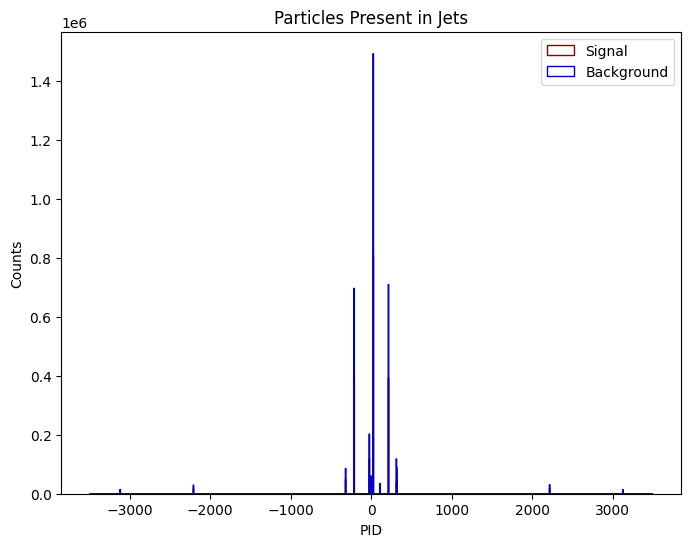

In [77]:
# Plot of Jet 0 Daughters PID (not including some outliers
plt.figure(figsize=(8, 6))
plt.hist(sig_id_list, label='Signal', bins=1000, range=[-3500,3500], histtype='step', color='darkred')
plt.hist(bkg_id_list, label='Background', bins=1000, range=[-3500,3500], histtype='step', color='mediumblue')

plt.xlabel('PID');
plt.ylabel('Counts');
plt.title('Particles Present in Jets');
plt.legend(loc='best');
plt.show()

plt.text(-300, 200000, '-321: K $^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-200, 800000, '-211: π $^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-25, 300000, '-22: γ', horizontalalignment='center', verticalalignment='center')
plt.text(-100, 200000, '-13: µ $^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(-100, 100000, '-11: e $^{+}$', horizontalalignment='center', verticalalignment='center')

plt.text(90, 100000, '11: e $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(90, 200000, '13: µ $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-25, 1400000, '22: γ', horizontalalignment='center', verticalalignment='center')
plt.text(90, 300000, '111: π $^{0}$', horizontalalignment='left', verticalalignment='center')
plt.text(211, 850000, '211: π $^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(280, 250000, '310: K$^{0}_{s}$', horizontalalignment='left', verticalalignment='center')
plt.text(280, 350000, '321: K $^{+}$', horizontalalignment='left', verticalalignment='center')

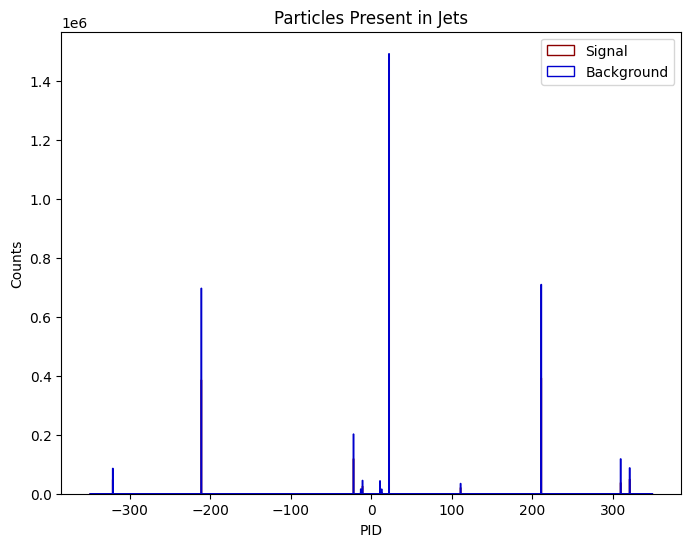

In [78]:
# Plot of Daughters PID in range of pions and kaons
plt.figure(figsize=(8, 6))
plt.hist(sig_id_list, label='Signal', bins=1000, range=[-350,350], histtype='step', color='darkred')
plt.hist(bkg_id_list, label='Background', bins=1000, range=[-350,350], histtype='step', color='mediumblue')

plt.xlabel('PID');
plt.ylabel('Counts');
plt.title('Particles Present in Jets');
plt.legend(loc='best');
plt.show()

In [79]:
train_sig_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsC
4,0.8031,-0.1643,35.4113,0.0060,0.0058,0.0338,69.060799,189,0.802931,-0.162520,...,True,True,True,True,True,True,True,True,False,1
5,0.8231,-0.2422,-35.5377,0.0215,0.0200,0.1711,11.610502,21,0.847809,-0.113981,...,True,False,True,True,True,True,True,True,False,1
8,0.8638,-0.1719,25.7751,0.0080,0.0084,0.0453,58.886047,135,0.863123,-0.171702,...,True,True,True,True,True,True,True,True,True,1
10,0.8674,-0.1683,-24.2661,0.0260,0.0233,0.1156,9.431437,19,0.867468,-0.161640,...,True,True,True,True,True,True,True,True,True,1
12,0.9166,-0.1825,-15.5003,0.0121,0.0109,0.0570,23.889086,59,0.910499,-0.183005,...,True,True,True,True,True,True,True,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290458,0.8934,-0.2297,-48.8540,0.0110,0.0109,0.0740,36.725994,83,0.893422,-0.230221,...,True,True,True,True,True,True,True,True,False,1
290460,0.8369,-0.2126,-59.9443,0.0112,0.0113,0.0702,15.497961,45,0.836708,-0.212240,...,False,False,False,True,False,False,True,False,False,1
290462,0.8499,-0.1670,-15.0021,0.0069,0.0069,0.0339,77.915245,179,0.849924,-0.166111,...,True,True,True,True,True,True,True,True,True,1
290463,0.8503,-0.2373,-28.9472,0.0388,0.0428,0.3991,4.984794,7,0.846310,-0.191067,...,False,False,False,True,False,False,True,False,False,1


In [80]:
# Split data 80:20 w equal parts sig/bkg then shuffle
sig_df = full_df[full_df['IsC'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = full_df[full_df['IsC'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

train_size = 160000
test_size = 40000

train_df = pd.concat([sig_df.head(train_size), bkg_df.head(train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_df.tail(test_size), bkg_df.tail(test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
validation_df = pd.concat([sig_df.iloc[train_size:-test_size], bkg_df.iloc[train_size:-test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)

daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = [col for col in sig_df.columns if "SVtag" in col]
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

# Create node feature array: [jet][daughter][feature]
def node_features(df):
    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

# Create graphs for each jet - orig
def create_data_objects(df, features_array):
    data_objects = []
    for idx, features in enumerate(features_array):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsC'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(train_df)
test_features = node_features(test_df)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [81]:
# Print adjacency matrix
G = nx.Graph()
G.add_edges_from(train_loader.dataset[0].edge_index.t().tolist())
A = nx.adjacency_matrix(G)
print(A.todense())

[[0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 0]]


In [ ]:
# Visualize some graphs
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, data in enumerate(train_loader.dataset[:6]):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    nx.draw(G, ax=axes[i], node_color='navy', node_size=100)
    
    axes[i].set_title(f"Graph {i+1}: {data.num_nodes} nodes, {data.edge_index.size(1)} edges")

plt.tight_layout()
plt.show()